<a href="https://colab.research.google.com/github/sidorov-ka/GM-HSE-AI-HWs/blob/master/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

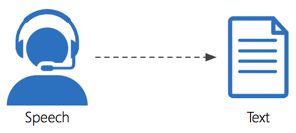

In [1]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [2]:
# ШАГ 1. Whisper-small на 10 случайных аудио из датасета
import os, random, shutil, requests
from pathlib import Path
import torch, torchaudio
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# --- папки
ROOT = Path("/content/data_stt"); ROOT.mkdir(parents=True, exist_ok=True)
AUDIO_DIR = ROOT / "audio"
if AUDIO_DIR.exists():
    shutil.rmtree(AUDIO_DIR)
AUDIO_DIR.mkdir(parents=True, exist_ok=True)

# --- скачиваем список URL из задания
PUBLIC_URL = "https://disk.yandex.ru/d/v2Hipv7XG4fEDQ"
OUT_PATH = Path("/content/urls_normalized.tsv")

def get_direct_link(yadisk_url: str) -> str:
    api = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    r = requests.get(api, params={"public_key": yadisk_url})
    r.raise_for_status()
    return r.json()["href"]

print("Скачиваю urls_normalized.tsv с Яндекс.Диска...")
tsv_bytes = requests.get(get_direct_link(PUBLIC_URL)).content
OUT_PATH.write_bytes(tsv_bytes)
print(f"Файл сохранён по пути: {OUT_PATH.resolve()}")

# --- читаем URL и выбираем 10 случайных
urls = [ln.strip() for ln in OUT_PATH.read_text(encoding="utf-8", errors="ignore").splitlines()
        if ln.strip().startswith("http")]
random.seed(42)
picked = random.sample(urls, k=min(10, len(urls)))

# --- скачиваем эти 10 аудио
downloaded = []
for i, url in enumerate(picked, 1):
    try:
        r = requests.get(url, stream=True, timeout=60); r.raise_for_status()
        name = url.split("?")[0].rstrip("/").split("/")[-1] or f"file_{i}"
        if "." not in name:  # у некоторых ссылок нет расширения
            name += ".wav"
        out = AUDIO_DIR / name
        with open(out, "wb") as f:
            for chunk in r.iter_content(8192):
                if chunk:
                    f.write(chunk)
        downloaded.append(out)
    except Exception as e:
        print("Ошибка при скачивании:", e)

files10 = downloaded[:10]

# --- готовим модель и процессор
MODEL_ID = "openai/whisper-small"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = WhisperProcessor.from_pretrained(MODEL_ID)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID).to(device).eval()

# также вам может пригодиться установить распознавание русского языка как гиперпараметр whisper-small, так как наш датасет русскоязычный
# фиксируем русский язык и задачу "transcribe" (чтобы НЕ переводил)
forced_ids = processor.get_decoder_prompt_ids(language="ru", task="transcribe")

# --- утилита загрузки и ресэмплинга в 16 kHz
def load_audio_16k(path: str):
    wav, sr = torchaudio.load(path)
    if wav.dim() > 1:                # стерео -> моно
        wav = wav.mean(dim=0, keepdim=True)
    # пересэмплируйте имеющиеся аудио в 16 kHz - пример кода ниже, можете его менять
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
        sr = 16000
    return wav.squeeze(0), sr

# --- инференс
torch.set_grad_enabled(False)

results = []
for f in files10:
    wav, sr = load_audio_16k(str(f))
    feats = processor(wav.numpy(), sampling_rate=sr, return_tensors="pt").input_features.to(device)
    pred_ids = model.generate(
        input_features=feats,
        forced_decoder_ids=forced_ids,   # ключевая строка для RU+transcribe
        max_new_tokens=128
    )
    text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0].strip()
    results.append((Path(f).name, text))

# --- выводим результаты
for i, (name, text) in enumerate(results, 1):
    print(f"[{i:02d}] {name}: {text}")


Скачиваю urls_normalized.tsv с Яндекс.Диска...
Файл сохранён по пути: /content/urls_normalized.tsv


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[01] eebe7151-43f7-4e5f-af3d-d7a1a3ab2197.wav: Александр Владимирович Попов
[02] fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.wav: Андрей Сахаров
[03] 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav: Дайон Уорвик
[04] 09c0c412-2316-4bf4-9f92-8349067de618.wav: Брюс Springsteam
[05] 47b9b402-e832-438d-ad85-3f7375867e4a.wav: КОУ ПОРТЕР
[06] 86aaebac-a43a-4f80-a6e4-136bfb5492e3.wav: Голова ломка.
[07] 373c13d2-0039-4ca1-a549-1563d2a8ef0a.wav: Крестный отец 2
[08] 2a6d78d6-5b79-4ec1-bd9b-29b59c1960c1.wav: Дай не трехо.
[09] 29c0f7f4-9701-4e19-a4cd-874ec5397be1.wav: Эффект бабочки.
[10] 1f418f48-7d16-41c4-b1ec-a06ec58aacfd.wav: Старший сын


## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [4]:
# Шаг 2. Предобученный корректор орфографии (T5)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

SPELL_MODEL = "UrukHan/t5-russian-spell"
device = "cuda" if torch.cuda.is_available() else "cpu"

spell_tok = AutoTokenizer.from_pretrained(SPELL_MODEL, use_fast=True)
spell_model = AutoModelForSeq2SeqLM.from_pretrained(SPELL_MODEL)
# --- безопасные дефолты для спец-токенов
if spell_tok.pad_token is None and spell_tok.eos_token is not None:
    spell_tok.pad_token = spell_tok.eos_token
spell_model.config.pad_token_id = spell_tok.pad_token_id
spell_model.config.eos_token_id = spell_tok.eos_token_id
spell_model.config.decoder_start_token_id = spell_tok.pad_token_id
spell_model = spell_model.to(device).eval()

# --- берём 10 текстов из шага 1
pred_names = [n for n, _ in results][:10]
pred_texts = [(t or "").strip() for _, t in results][:10]

# --- готовим входы для T5
inputs = [f"fix: {txt[:300]}" for txt in pred_texts]  # страховочный срез
enc = spell_tok(
    inputs,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
).to(device)

with torch.no_grad():
    out_ids = spell_model.generate(
        **enc,
        max_new_tokens=64,
        num_beams=6,                 # чуть стабильнее
        no_repeat_ngram_size=3,      # меньше повторов
        early_stopping=True
    )

corrected = spell_tok.batch_decode(out_ids, skip_special_tokens=True)

# --- вывод «до → после»
for i, (name, orig, corr) in enumerate(zip(pred_names, pred_texts, corrected), 1):
    print(f"[{i:02d}] {name}")
    print("   asr: ", orig)
    print("   fix: ", corr)
    print("-" * 80)

[01] eebe7151-43f7-4e5f-af3d-d7a1a3ab2197.wav
   asr:  Александр Владимирович Попов
   fix:  Александр Владимирович Попов
--------------------------------------------------------------------------------
[02] fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.wav
   asr:  Андрей Сахаров
   fix:  Андрей Сахаров
--------------------------------------------------------------------------------
[03] 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav
   asr:  Дайон Уорвик
   fix:  Дайон Уорвик
--------------------------------------------------------------------------------
[04] 09c0c412-2316-4bf4-9f92-8349067de618.wav
   asr:  Брюс Springsteam
   fix:  Брюс Брюс.
--------------------------------------------------------------------------------
[05] 47b9b402-e832-438d-ad85-3f7375867e4a.wav
   asr:  КОУ ПОРТЕР
   fix:  КОУ ПОРТЕР (Fix)
--------------------------------------------------------------------------------
[06] 86aaebac-a43a-4f80-a6e4-136bfb5492e3.wav
   asr:  Голова ломка.
   fix:  Голова ломка.
-------------

## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

In [31]:
# ШАГ 3.1 Установка и запуск Ollama + проверка API + загрузка модели
# Цель: поднять локальную LLM без лимитов и проверить ответ.

# --- установка (Linux/Colab). На Windows/Mac поставьте с сайта и пропустите этот шаг.
!curl -fsSL https://ollama.com/install.sh | sh

import time, json, requests, subprocess, os
from pathlib import Path

# --- запуск сервера Ollama в фоне (в Colab нет systemd)
_ = subprocess.Popen(["ollama", "serve"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

# --- ожидание API http://127.0.0.1:11434
OLLAMA_BASE_URL = os.environ.get("OLLAMA_URL", "http://127.0.0.1:11434")
for i in range(60):
    try:
        r = requests.get(f"{OLLAMA_BASE_URL}/api/tags", timeout=2)
        if r.ok:
            print("Ollama API доступен")
            break
    except Exception:
        pass
    time.sleep(1)
else:
    raise RuntimeError("Ollama API не поднялся за разумное время")

# --- выбор модели (оптимальный компромисс между скоростью и качеством)
OLLAMA_MODEL = os.environ.get("OLLAMA_MODEL", "qwen2.5:3b")
print("Используем модель:", OLLAMA_MODEL)

# --- проверяем, есть ли модель локально
def have_model(name: str) -> bool:
    try:
        r = requests.get(f"{OLLAMA_BASE_URL}/api/tags", timeout=10)
        r.raise_for_status()
        tags = [m.get("name") for m in r.json().get("models", [])]
        return name in tags
    except Exception:
        return False

# --- скачиваем модель, если её нет
if not have_model(OLLAMA_MODEL):
    print("Модель не найдена локально — начинаю загрузку...")
    pull = subprocess.run(["ollama", "pull", OLLAMA_MODEL], capture_output=True, text=True)
    print(pull.stdout or pull.stderr)
else:
    print("Модель уже есть локально, пропускаю загрузку.")

# --- мини-проверка: запрос к /api/generate
payload = {
    "model": OLLAMA_MODEL,
    "prompt": "Ответь 'OK' без лишних слов.",
    "stream": False
}
resp = requests.post(f"{OLLAMA_BASE_URL}/api/generate", json=payload, timeout=60)
print("Проверка:", (resp.json().get("response", "") or "")[:80])

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Ollama API доступен
Используем модель: qwen2.5:3b
Модель не найдена локально — начинаю загрузку...
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling 5ee4f07cdb9b:   0% ▕                  ▏  58 KB/1.9 GB                  pulling manifest 
pulling 5ee4f07cdb9b:   1% ▕                  ▏  21 MB/1.9 GB                  pulling manifest 
pulling 5ee4f07cdb9b:   3% ▕                  ▏  53 MB/1.9 GB                  pulling manifest 
pulling 5ee4f07cdb9b:   4% ▕         

In [32]:
# ШАГ 3.2 Генерация датасета >1000 строк (noisy -> clean) и сохранение в CSV
# Цель: собрать пары для корректора опечаток с ASR-подобным шумом на Ollama (qwen2.5:3b).

!pip -q install pandas tqdm

import os, re, csv, json, time, random, requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

# --- настройки
OLLAMA_BASE_URL = os.environ.get("OLLAMA_URL", "http://127.0.0.1:11434")
OLLAMA_MODEL    = os.environ.get("OLLAMA_MODEL", "qwen2.5:3b")

OUT_CSV     = Path("/content/spell_dataset.csv")
TARGET_ROWS = 1200                 # >1000 для зачёта
BATCH_SIZE  = 20                   # 16–24 обычно стабильно
DOMAINS     = ["быт","интернет","новости","общение","технологии","путешествия","образование","медицина"]
random.seed(42)

# --- утилиты
def _normalize_quotes(text: str) -> str:
    return (text or "").replace("“","\"").replace("”","\"").replace("„","\"")\
                       .replace("«","\"").replace("»","\"").replace("’","'").replace("‘","'")

def parse_pairs_from_text(text: str):
    text = _normalize_quotes(text)
    pairs = []
    # построчно — JSONL
    for line in text.splitlines():
        line = line.strip().strip("`,")
        if not line:
            continue
        m = re.search(r"\{.*?\}", line)
        if not m:
            continue
        try:
            obj = json.loads(m.group(0))
        except json.JSONDecodeError:
            continue
        noisy = str(obj.get("noisy","")).strip()
        clean = str(obj.get("clean","")).strip()
        if noisy and clean and noisy != clean and len(noisy) <= 300 and len(clean) <= 300:
            pairs.append({"noisy": noisy, "clean": clean})
    # из цельного текста — все объекты
    if not pairs:
        for m in re.finditer(r"\{[^{}]*\"noisy\"[^{}]*\"clean\"[^{}]*\}", text, flags=re.S):
            try:
                obj = json.loads(m.group(0))
            except json.JSONDecodeError:
                continue
            noisy = str(obj.get("noisy","")).strip()
            clean = str(obj.get("clean","")).strip()
            if noisy and clean and noisy != clean and len(noisy) <= 300 and len(clean) <= 300:
                pairs.append({"noisy": noisy, "clean": clean})
    return pairs

def norm_key(noisy: str, clean: str) -> tuple[str, str]:
    def norm(s: str) -> str:
        return re.sub(r"\s+", " ", s).strip()
    return (norm(noisy), norm(clean))

def atomic_save(rows, path: Path):
    tmp = path.with_suffix(path.suffix + ".tmp")
    pd.DataFrame(rows).to_csv(tmp, index=False, encoding="utf-8", quoting=csv.QUOTE_MINIMAL)
    tmp.replace(path)

# --- промпт под ASR-шум
FEW_SHOT = """Примеры формата JSONL:
{"noisy": "segodnya budet dozd vozmi zontik", "clean": "Сегодня будет дождь, возьми зонт"}
{"noisy": "Ya lublu programirovat na pyton",  "clean": "Я люблю программировать на Python"}
{"noisy": "v 7 vechera nachnem",              "clean": "В семь вечера начнём"}
{"noisy": "dlya etogo nuzhno prov verif",     "clean": "Для этого нужно провести верификацию"}
"""

def build_prompt(n, domain):
    return f"""Сгенерируй РОВНО {n} пар русскоязычных предложений в домене: {domain}.
Вывод строго в формате JSONL (каждая строка — отдельный объект): {{"noisy": "...", "clean": "..."}}
Требования к "noisy":
- 1–3 ошибки, характерные для ASR: слитные/раздельные слова, пропуски коротких слов/частиц,
  рус↔лат буквы (p/р, a/а, e/е, o/о), "ё"→"е", пунктуация/регистр, цифры↔слова, редкие омонимии/оглушения.
- Смысл максимально сохраняется, длина близка к clean.
"clean" — полностью корректный русский вариант.
Никакого текста, кроме JSONL. Без бэктиков и кода.
{FEW_SHOT}
""".strip()

def ollama_chat(prompt: str, temperature=0.9, retries=3, sleep=3):
    url = f"{OLLAMA_BASE_URL}/api/generate"
    payload = {"model": OLLAMA_MODEL, "prompt": prompt, "options": {"temperature": float(temperature)}, "stream": True}
    last_err = None
    for attempt in range(retries):
        try:
            r = requests.post(url, json=payload, timeout=180, stream=True)
            r.raise_for_status()
            chunks = []
            for line in r.iter_lines():
                if not line:
                    continue
                try:
                    obj = json.loads(line.decode("utf-8"))
                except Exception:
                    continue
                if "response" in obj:
                    chunks.append(obj["response"])
                if obj.get("done"):
                    break
            return "".join(chunks)
        except Exception as e:
            last_err = e
            time.sleep(sleep * (attempt + 1))
    print(f"[fatal] Ollama error: {last_err}")
    return ""

def gen_pairs_block(n, domain):
    text = ollama_chat(build_prompt(n, domain), temperature=0.9)
    pairs = parse_pairs_from_text(text)
    if not pairs:
        text = ollama_chat(build_prompt(n, domain), temperature=0.95)
        pairs = parse_pairs_from_text(text)
    return pairs[:n]

# --- резюмирование с существующего CSV (если уже делали)
seen, all_rows = set(), []
if OUT_CSV.exists() and OUT_CSV.stat().st_size > 0:
    try:
        prev = pd.read_csv(OUT_CSV).astype(str)
        for _, r in prev.iterrows():
            k = norm_key(r["noisy"], r["clean"])
            if k not in seen:
                seen.add(k); all_rows.append({"noisy": k[0], "clean": k[1]})
        print(f"Резюмирование: найдено {len(all_rows)} строк в {OUT_CSV}")
    except Exception:
        print("Предыдущий CSV повреждён, начну с нуля.")

# --- основной цикл
with tqdm(total=TARGET_ROWS, desc="Сбор пар") as pbar:
    pbar.update(len(all_rows))
    empty_blocks = 0
    while len(all_rows) < TARGET_ROWS:
        dom = random.choice(DOMAINS)
        batch = gen_pairs_block(BATCH_SIZE, dom)
        added = 0
        for p in batch:
            k = norm_key(p["noisy"], p["clean"])
            if k not in seen:
                seen.add(k)
                all_rows.append({"noisy": k[0], "clean": k[1]})
                added += 1

        if added == 0:
            empty_blocks += 1
            print(f"[warn] Пустая партия ({empty_blocks}). Проверь видеопамять/модель/температуру.")
            if empty_blocks >= 5:
                print("[stop] 5 пустых партий подряд — выходим, проверь окружение.")
                break
        else:
            empty_blocks = 0

        pbar.update(added)
        if len(all_rows) % 200 == 0:
            atomic_save(all_rows, OUT_CSV)
            print(f"\nЧекпоинт -> {OUT_CSV} ({len(all_rows)} строк)")

# --- финальная запись
atomic_save(all_rows, OUT_CSV)
print(f"Сохранено {len(all_rows)} строк -> {OUT_CSV}")

# --- превью
df = pd.read_csv(OUT_CSV)
for i, row in df.head(10).iterrows():
    print(f"[{i+1:02d}]")
    print("   noisy:", row["noisy"])
    print("   clean:", row["clean"])
    print("---")

Сбор пар:   0%|          | 0/1200 [00:00<?, ?it/s]

Сохранено 1201 строк -> /content/spell_dataset.csv
[01]
   noisy: Я устроил прогрессивный ритм на моей синхронной платформе
   clean: Я создал прогрессивный ритм на своей синхронной платформе
---
[02]
   noisy: Сегодня я возвращаюсь к старым программам Python
   clean: Сегодня я возвращаюсь к старым языкам программирования Python
---
[03]
   noisy: На сайте я обнаружил, что мой аккаунт взломан
   clean: На сайте я обнаружил, что мой аккаунт был взломан
---
[04]
   noisy: Я уже пытался связаться с поддержкой по поводу моего вопроса но они не отвечали
   clean: Я уже пытался связаться с поддержкой по поводу своего вопроса, но они не отвечали
---
[05]
   noisy: Вчера я получил доступ к чужому аккаунту на моей платформе
   clean: Вчера я получил доступ к чужому аккаунту на своей платформе
---
[06]
   noisy: Я хочу чтобы мои данные не были проданы в интернете
   clean: Я хочу, чтобы мои данные не были проданы в Интернете
---
[07]
   noisy: Всемирный интернет стал более безопасным
   clean: 

In [33]:
# ШАГ 3.3 Публикация ЛОКАЛЬНОГО CSV → Hugging Face Datasets (один датасет noisy/clean)
# Цель: взять /content/spell_dataset.csv и запушить в ваш репозиторий на HF.

!pip -q install datasets huggingface_hub

import pandas as pd
from datasets import Dataset, DatasetDict
from huggingface_hub import login, whoami, HfApi

# --- интерактивный ввод токена HF (write)
from getpass import getpass
token = getpass("Введите ваш HuggingFace токен (write): ")
login(token=token)

me = whoami()
USER = me["name"]
print("Успешный вход в аккаунт:", USER)

# --- пути и чтение локального файла
CSV_PATH = "/content/spell_dataset.csv"
df = pd.read_csv(CSV_PATH).dropna().astype(str)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
df = df[["noisy", "clean"]]
print("Превью:")
print(df.head(3))

# --- создаём HF Dataset и делаем сплит 90/10
ds  = Dataset.from_pandas(df, preserve_index=False)
dds = ds.train_test_split(test_size=0.1, seed=42)
dds = DatasetDict({"train": dds["train"], "validation": dds["test"]})
print(dds)

# --- создаём репозиторий и пушим датасет
api = HfApi()
REPO = f"{USER}/spell-ru-asr-synthetic"   # имя репозитория на HF (можно поменять)
api.create_repo(REPO, repo_type="dataset", private=False, exist_ok=True)
dds.push_to_hub(REPO)

print("\nГотово!")
print(f"Ссылка на датасет: https://huggingface.co/datasets/{REPO}")


Введите ваш HuggingFace токен (write): ··········
Успешный вход в аккаунт: SiDoor
Превью:
                                               noisy  \
0  Министр заявил, что Россия не имеет отношения ...   
1            Это антибиотик помогло мне выздороветь.   
2                  Для этого нужна сима с перчатками   

                                               clean  
0  Министр заявил, что Россия не имеет отношений ...  
1             Этот антибиотик помог мне выздороветь.  
2             Для этого нужна SIM-карта с перчатками  
DatasetDict({
    train: Dataset({
        features: ['noisy', 'clean'],
        num_rows: 1080
    })
    validation: Dataset({
        features: ['noisy', 'clean'],
        num_rows: 121
    })
})


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  115kB /  115kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 15.3kB / 15.3kB            

                              : 100%|##########| 15.3kB / 15.3kB            


Готово!
Ссылка на датасет: https://huggingface.co/datasets/SiDoor/spell-ru-asr-synthetic


## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [37]:
# ШАГ 4. Дообучение T5-корректора на своём датасете и сохранение чекпоинта

!pip -q install -U transformers datasets accelerate evaluate

import os, re, random
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

# --- воспроизводимость
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.set_grad_enabled(True)

# --- модель и пути
BASE_MODEL = "UrukHan/t5-russian-spell"
DATA_CSV   = "/content/spell_dataset.csv"
OUT_DIR    = "/content/models/spell-ft"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# --- лимиты и батчи
MAX_LEN_IN, MAX_LEN_OUT = 128, 128
BATCH_TRAIN = 16 if torch.cuda.is_available() else 4
BATCH_EVAL  = 16 if torch.cuda.is_available() else 4
EPOCHS      = 3
LR          = 5e-5

# --- токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
model.config.use_cache = False
if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
    tokenizer.pad_token = tokenizer.eos_token
model.to(DEVICE)

# --- читаем и чистим CSV
assert Path(DATA_CSV).exists(), f"Файл не найден: {DATA_CSV}"
df = pd.read_csv(DATA_CSV)

c_in  = next((c for c in df.columns if c.lower() in ("input","src","source","noisy","asr","text","prompt")), None)
c_tgt = next((c for c in df.columns if c.lower() in ("target","tgt","clean","fix","label","answer","gt")), None)
if not c_in or not c_tgt:
    raise ValueError(f"Не найдены колонки вход/цель. Есть: {df.columns.tolist()}")

df[c_in]  = df[c_in].astype(str).str.strip()
df[c_tgt] = df[c_tgt].astype(str).str.strip()
df = df.dropna(subset=[c_in, c_tgt])
df = df[(df[c_in] != "") & (df[c_tgt] != "")]
df = df.drop_duplicates(subset=[c_in, c_tgt]).drop_duplicates(subset=[c_in])
df = df[(df[c_in].str.len() <= 300) & (df[c_tgt].str.len() <= 300)]
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

full_ds = Dataset.from_pandas(df[[c_in, c_tgt]], preserve_index=False)
dataset = full_ds.train_test_split(test_size=0.1, seed=SEED)
train_ds, val_ds = dataset["train"], dataset["test"]

# --- токенизация
def preprocess(batch):
    inputs = [f"fix: {x}" for x in batch[c_in]]
    enc = tokenizer(inputs, max_length=MAX_LEN_IN, truncation=True)
    labels = tokenizer(text_target=batch[c_tgt], max_length=MAX_LEN_OUT, truncation=True)
    enc["labels"] = labels["input_ids"]
    return enc

train_tok = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(preprocess,   batched=True, remove_columns=val_ds.column_names)

# --- data collator
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding="longest")

# --- метрики
def _lev(a, b):
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    dp = list(range(m + 1))
    for i in range(1, n + 1):
        prev, dp[0] = dp[0], i
        for j in range(1, m + 1):
            tmp = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = tmp
    return dp[m]

def _decode(pred_ids, label_ids):
    label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)
    preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    refs  = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    preds = [p.strip() for p in preds]
    refs  = [r.strip() for r in refs]
    return preds, refs

def _wer(refs, hyps):
    vals = []
    for r, h in zip(refs, hyps):
        rw, hw = r.split(), h.split()
        vals.append(_lev(rw, hw) / max(1, len(rw)))
    return float(np.mean(vals))

def _cer(refs, hyps):
    vals = []
    for r, h in zip(refs, hyps):
        vals.append(_lev(list(r), list(h)) / max(1, len(r)))
    return float(np.mean(vals))

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    p_txt, r_txt = _decode(preds, labels)
    return {
        "cer": _cer(r_txt, p_txt),
        "wer": _wer(r_txt, p_txt),
        "string_acc": float(np.mean([int(p == r) for p, r in zip(p_txt, r_txt)])),
    }

# --- аргументы обучения
# Если transformers >= 4.45, используйте eval_strategy. Если <= 4.44, замените на evaluation_strategy.
args = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=2,
    learning_rate=LR,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    predict_with_generate=True,
    generation_max_length=MAX_LEN_OUT,
    fp16=torch.cuda.is_available(),
    report_to="none",
    remove_unused_columns=False,
    seed=SEED,
    dataloader_num_workers=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

# --- обучение
trainer.train()

# --- сохранение
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

ok = any(os.path.exists(os.path.join(OUT_DIR, f)) for f in ("pytorch_model.bin", "model.safetensors"))
assert ok, f"В {OUT_DIR} нет файлов весов."
print("Saved to:", OUT_DIR)


Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Cer,Wer,String Acc
1,No log,1.327216,0.329909,0.527326,0.133333
2,1.495000,1.257902,0.319203,0.509647,0.150000
3,1.017800,1.241062,0.317744,0.506159,0.150000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Saved to: /content/models/spell-ft


In [38]:
# Применение дообученной модели: 10 текстов Whisper -> исправления

import os, torch, pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/models/spell-ft"
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Файлы в чекпоинте:", os.listdir(model_path))

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else None,
).to(device).eval()

def generate_fix(texts, max_new_tokens=96, num_beams=6):
    prompts = [f"fix: {t}" for t in texts]
    enc = tokenizer(prompts, return_tensors="pt", padding=True,
                    truncation=True, max_length=128).to(device)
    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            early_stopping=True,
            no_repeat_ngram_size=3
        )
    return tokenizer.batch_decode(out_ids, skip_special_tokens=True)

# --- берём 10 примеров: если есть 'results' из шага 1 — используем их; иначе из валидации CSV
try:
    pred_names = [n for n, _ in results][:10]
    asr_texts  = [t for _, t in results][:10]
except Exception:
    df_tmp = pd.read_csv("/content/spell_dataset.csv")
    src_col = next(c for c in df_tmp.columns if c.lower() in ("noisy","input","src","source","asr","text"))
    asr_texts  = df_tmp[src_col].astype(str).tolist()[:10]
    pred_names = [f"sample_{i:02d}" for i in range(len(asr_texts))]

fixed = generate_fix(asr_texts)

for i, (name, src, fx) in enumerate(zip(pred_names, asr_texts, fixed), 1):
    print(f"[{i:02d}] {name}")
    print("ASR :", src)
    print("FIX :", fx)
    print("-" * 80)

`torch_dtype` is deprecated! Use `dtype` instead!


Файлы в чекпоинте: ['config.json', 'checkpoint-34', 'training_args.bin', 'tokenizer.json', 'checkpoint-102', 'tokenizer_config.json', 'special_tokens_map.json', 'generation_config.json', 'checkpoint-68', 'spiece.model', 'model.safetensors']
[01] eebe7151-43f7-4e5f-af3d-d7a1a3ab2197.wav
ASR : Александр Владимирович Попов
FIX : Александр Владимирович Попов
--------------------------------------------------------------------------------
[02] fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.wav
ASR : Андрей Сахаров
FIX : Андрей Сахаров
--------------------------------------------------------------------------------
[03] 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav
ASR : Дайон Уорвик
FIX : Дайон Уорвик
--------------------------------------------------------------------------------
[04] 09c0c412-2316-4bf4-9f92-8349067de618.wav
ASR : Брюс Springsteam
FIX : Брюс.
--------------------------------------------------------------------------------
[05] 47b9b402-e832-438d-ad85-3f7375867e4a.wav
ASR : КОУ ПОРТЕР
FIX

## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [41]:
# ШАГ 5.1 Получаем ASR строго по тем файлам, что есть в answers.json (RU + transcribe)

import os, re, json, unicodedata, requests, random, shutil
import numpy as np, pandas as pd
from pathlib import Path
import torch, torchaudio
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# --- пути и ссылки
URLS_TSV_URL = "https://disk.yandex.ru/d/v2Hipv7XG4fEDQ"     # тот самый список всех URL аудио (из условия Шага 1)
ANSWERS_URL  = "https://disk.yandex.net/d/SPJU3lCt_cMDcw"    # answers.json (референсы)
ROOT         = Path("/content/data_stt_eval"); ROOT.mkdir(parents=True, exist_ok=True)
AUDIO_DIR    = ROOT / "audio"; AUDIO_DIR.mkdir(exist_ok=True)
TSV_PATH     = ROOT / "urls_normalized.tsv"
ANSWERS_PATH = ROOT / "answers.json"

def get_direct_link(yadisk_url: str) -> str:
    api = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    r = requests.get(api, params={"public_key": yadisk_url}); r.raise_for_status()
    return r.json()["href"]

# --- качаем TSV и answers.json
tsv_bytes = requests.get(get_direct_link(URLS_TSV_URL)).content
TSV_PATH.write_bytes(tsv_bytes)
ans_bytes = requests.get(get_direct_link(ANSWERS_URL)).content
ANSWERS_PATH.write_bytes(ans_bytes)

# --- парсим answers.json
with open(ANSWERS_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
gold_arr = data["results"] if isinstance(data, dict) and isinstance(data.get("results"), list) else data
gold = pd.DataFrame(gold_arr)

# --- вытаскиваем имя файла и текст-референс
def basename_no_ext(s: str) -> str:
    s = str(s).strip()
    if "/" in s: s = s.rstrip("/").split("/")[-1]
    return s[:-4] if s.lower().endswith(".wav") else s

name_col = next(c for c in gold.columns if c.lower() in {"name","id","filename","file","audio","url","path"})
ref_col  = next(c for c in gold.columns if c.lower() in {"ref","text","target","gt","answer","transcript"})
gold = gold[[name_col, ref_col]].rename(columns={name_col:"name_ref", ref_col:"ref"})
gold["name_ref"] = gold["name_ref"].apply(basename_no_ext)
gold = gold.dropna(subset=["name_ref","ref"]).reset_index(drop=True)

# --- строим маппинг name -> url из TSV
rows = []
for ln in TSV_PATH.read_text(encoding="utf-8", errors="ignore").splitlines():
    ln = ln.strip()
    if ln.startswith("http"):
        fname = ln.split("?")[0].rstrip("/").split("/")[-1]
        base  = fname[:-4] if fname.lower().endswith(".wav") else fname
        rows.append((base, ln))
urlmap = {k:v for k, v in rows}

# --- фильтруем только те, что реально есть в TSV
gold = gold[gold["name_ref"].isin(urlmap.keys())].reset_index(drop=True)
print("Файлов с референсами (по answers.json ∩ urls.tsv):", len(gold))

# --- скачиваем нужные wav
downloaded = []
for nm in gold["name_ref"]:
    url = urlmap[nm]
    out = AUDIO_DIR / f"{nm}.wav"
    if not out.exists():
        r = requests.get(url, stream=True, timeout=60); r.raise_for_status()
        with open(out, "wb") as f:
            for chunk in r.iter_content(8192):
                if chunk: f.write(chunk)
    downloaded.append(out)

# --- готовим whisper-small
MODEL_ID = "openai/whisper-small"
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = WhisperProcessor.from_pretrained(MODEL_ID)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID).to(device).eval()
forced_ids = processor.get_decoder_prompt_ids(language="ru", task="transcribe")

def load_audio_16k(path: str):
    wav, sr = torchaudio.load(path)
    if wav.dim() > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
        sr = 16000
    return wav.squeeze(0), sr

# --- ASR по всем таргетам из answers.json
torch.set_grad_enabled(False)
results = []  # список (name.wav, asr_text)
for p in downloaded:
    wav, sr = load_audio_16k(str(p))
    feats = processor(wav.numpy(), sampling_rate=sr, return_tensors="pt").input_features.to(device)
    pred_ids = model.generate(input_features=feats, forced_decoder_ids=forced_ids, max_new_tokens=128)
    text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0].strip()
    results.append((p.name, text))

print("ASR готово. Примеров:", len(results))


Файлов с референсами (по answers.json ∩ urls.tsv): 96


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

ASR готово. Примеров: 96


In [43]:
# ШАГ 5.2 Счёт WER для (a) whisper, (b) whisper+base, (c) whisper+finetuned

import os, re, json, unicodedata
import numpy as np, pandas as pd
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# входы из шага 5А:
# - ANSWERS_PATH: путь к answers.json
# - results: список (name.wav, asr_text), полученный ровно по answers.json
assert 'results' in globals(), "Нет переменной results из шага 5А. Сначала прогоните ячейку 5А."
assert 'ANSWERS_PATH' in globals() and Path(ANSWERS_PATH).exists(), "Нет answers.json. Сначала прогоните ячейку 5А."

BASE_SPELL    = "UrukHan/t5-russian-spell"
FINETUNED_DIR = "/content/models/spell-ft"
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- парсер answers.json (точно как в 5А)
with open(ANSWERS_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
gold_arr = data["results"] if isinstance(data, dict) and isinstance(data.get("results"), list) else data
gold = pd.DataFrame(gold_arr)

def basename_no_ext(s: str) -> str:
    s = str(s).strip()
    if "/" in s: s = s.rstrip("/").split("/")[-1]
    return s[:-4] if s.lower().endswith(".wav") else s

name_col = next(c for c in gold.columns if c.lower() in {"name","id","filename","file","audio","url","path"})
ref_col  = next(c for c in gold.columns if c.lower() in {"ref","text","target","gt","answer","transcript"})
gold = gold[[name_col, ref_col]].rename(columns={name_col:"name_ref", ref_col:"ref"})
gold["name_ref"] = gold["name_ref"].apply(lambda x: (basename_no_ext(x) + ".wav"))
gold["ref"] = gold["ref"].astype(str).str.strip()

# --- ASR-гипотезы из 5А
asr_df = pd.DataFrame(results, columns=["name","asr"])
asr_df["name"] = asr_df["name"].astype(str)
asr_df["asr"]  = asr_df["asr"].astype(str)

# --- стыковка по ПОЛНОМУ имени файла (с .wav)
eval_df = asr_df.merge(gold, left_on="name", right_on="name_ref", how="inner")

if eval_df.empty:
    # Диагностика: покажем примеры имён для понимания рассинхрона
    print("Мерж дал 0 строк. Диагностика:")
    print("Примеры из ASR:", asr_df["name"].head(5).tolist())
    print("Примеры из GOLD:", gold["name_ref"].head(5).tolist())
    # Попробуем ещё вариант по basename (без .wav)
    asr_df2 = asr_df.copy()
    asr_df2["base"] = asr_df2["name"].apply(lambda s: basename_no_ext(s))
    gold2 = gold.copy()
    gold2["base"] = gold2["name_ref"].apply(lambda s: basename_no_ext(s))
    eval_df = asr_df2.merge(gold2, on="base", how="inner")
    if eval_df.empty:
        raise RuntimeError("Не удалось состыковать ASR и answers.json. Проверьте имена.")
    else:
        # вернём нормальные поля
        eval_df["name"] = eval_df["name_x"]
        eval_df = eval_df[["name","asr","ref"]]

else:
    eval_df = eval_df[["name","asr","ref"]]

eval_df = eval_df.reset_index(drop=True)
print("к оценке примеров:", len(eval_df))

# --- нормализация (одинакова для ref/hyp)
RU_NUM = {
    "0":"ноль","1":"один","2":"два","3":"три","4":"четыре","5":"пять","6":"шесть","7":"семь","8":"восемь","9":"девять",
    "10":"десять","11":"одиннадцать","12":"двенадцать","13":"тринадцать","14":"четырнадцать","15":"пятнадцать",
    "16":"шестнадцать","17":"семнадцать","18":"восемнадцать","19":"девятнадцать","20":"двадцать",
    "30":"тридцать","40":"сорок","50":"пятьдесят","60":"шестьдесят","70":"семьдесят","80":"восемьдесят","90":"девяносто"
}
def _num_to_words_token(tok: str) -> str:
    if not tok.isdigit(): return tok
    n = int(tok)
    if str(n) in RU_NUM: return RU_NUM[str(n)]
    if 21 <= n <= 99:
        tens = (n // 10) * 10; ones = n % 10
        return (RU_NUM.get(str(tens), str(tens)) + (" " + RU_NUM.get(str(ones), str(ones)) if ones else "")).strip()
    return tok

def normalize_numbers(s: str) -> str:
    tokens = re.findall(r"\d+|[^\d\s]+", s)
    out = [(_num_to_words_token(t) if t.isdigit() else t) for t in tokens]
    return re.sub(r"\s+", " ", " ".join(out)).strip()

def norm_text_strict(s: str) -> str:
    s = str(s).lower().strip()
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"\([^)]*\)\s*$", "", s)
    s = s.replace("ё", "е")
    s = s.translate(str.maketrans({"a":"а","e":"е","o":"о","c":"с","p":"р","x":"х","y":"у","k":"к","h":"н","b":"в","m":"м","t":"т"}))
    s = normalize_numbers(s)
    s = re.sub(r"[^\w\s]", " ", s, flags=re.UNICODE)
    s = s.replace("_", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _lev(a, b):
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    dp = list(range(m + 1))
    for i in range(1, n + 1):
        prev, dp[0] = dp[0], i
        for j in range(1, m + 1):
            tmp = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = tmp
    return dp[m]

def wer_vec(refs, hyps):
    vals = []
    for r, h in zip(refs, hyps):
        r_words = str(r).split()
        h_words = str(h).split()
        vals.append(_lev(r_words, h_words) / max(1, len(r_words)))
    return float(np.mean(vals))

# --- корректоры
base_tok = AutoTokenizer.from_pretrained(BASE_SPELL, use_fast=True)
base_mdl = AutoModelForSeq2SeqLM.from_pretrained(BASE_SPELL).to(device).eval()
ft_tok   = AutoTokenizer.from_pretrained(FINETUNED_DIR, use_fast=True)
ft_mdl   = AutoModelForSeq2SeqLM.from_pretrained(FINETUNED_DIR).to(device).eval()

def correct_batch(texts, mdl, tok, max_new_tokens=96, num_beams=8):
    if len(texts) == 0: return []
    prompts = [f"fix: {t}" for t in texts]
    enc = tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        out = mdl.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            length_penalty=1.2,
            early_stopping=False,
            no_repeat_ngram_size=3,
        )
    return tok.batch_decode(out, skip_special_tokens=True)

# --- исправления
eval_df["corr_base"] = correct_batch(eval_df["asr"].tolist(), base_mdl, base_tok)
eval_df["corr_ft"]   = correct_batch(eval_df["asr"].tolist(), ft_mdl,   ft_tok)

# --- WER raw
wer_whisper      = wer_vec(eval_df["ref"], eval_df["asr"])
wer_whisper_base = wer_vec(eval_df["ref"], eval_df["corr_base"])
wer_whisper_ft   = wer_vec(eval_df["ref"], eval_df["corr_ft"])
print("wer whisper-small (raw):                   ", round(wer_whisper, 5))
print("wer whisper-small + base-correction (raw): ", round(wer_whisper_base, 5))
print("wer whisper-small + fine-tuned (raw):      ", round(wer_whisper_ft, 5))

# --- WER normalized
dfn = eval_df.copy()
for col in ["ref","asr","corr_base","corr_ft"]:
    dfn[col+"_n"] = dfn[col].apply(norm_text_strict)

wer_whisper_n      = wer_vec(dfn["ref_n"], dfn["asr_n"])
wer_whisper_base_n = wer_vec(dfn["ref_n"], dfn["corr_base_n"])
wer_whisper_ft_n   = wer_vec(dfn["ref_n"], dfn["corr_ft_n"])
print("wer whisper-small (normalized):                   ", round(wer_whisper_n, 5))
print("wer whisper-small + base-correction (normalized): ", round(wer_whisper_base_n, 5))
print("wer whisper-small + fine-tuned (normalized):      ", round(wer_whisper_ft_n, 5))

# --- превью
print("\nПримеры (10 строк):")
for i, row in dfn.head(10).iterrows():
    print(f"[{i+1:02d}] {row['name']}")
    print("REF:", row["ref"])
    print("ASR:", row["asr"])
    print("BAS:", row["corr_base"])
    print("FT :", row["corr_ft"])
    print("-"*80)

к оценке примеров: 96
wer whisper-small (raw):                    0.92557
wer whisper-small + base-correction (raw):  1.03132
wer whisper-small + fine-tuned (raw):       0.97914
wer whisper-small (normalized):                    0.40613
wer whisper-small + base-correction (normalized):  0.45871
wer whisper-small + fine-tuned (normalized):       0.41357

Примеры (10 строк):
[01] 197f271b-b23f-4ee0-b240-e956a172d7af.wav
REF: жизнь других
ASR: Жизнь других.
BAS: Жизнь других
FT : Жизнь других.
--------------------------------------------------------------------------------
[02] 3d8c8d43-f7f2-479b-a857-c90faa5e2faf.wav
REF: элтон джон
ASR: Аутам Джон.
BAS: Аутам Джон.
FT : Аутам Джон.
--------------------------------------------------------------------------------
[03] 45161c4c-3f2c-4638-940e-a69404074ebb.wav
REF: побег из шоушенка
ASR: Побег из Шаушенко
BAS: Побег из Шаушенко
FT : Побег из Шаушенко
--------------------------------------------------------------------------------
[04] 63855

## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

In [44]:
# ШАГ 6.1 (ASR) Сравнение нескольких предобученных ASR-моделей на том же наборе (answers.json)
# По умолчанию прогоняем whisper-small и whisper-medium.

import time, torch, torchaudio, requests, json
import pandas as pd
from pathlib import Path
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# --- входы от шагов 5.1/5.2
assert 'ANSWERS_PATH' in globals() and Path(ANSWERS_PATH).exists(), "Сначала шаг 5A."
with open(ANSWERS_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
gold_arr = data["results"] if isinstance(data, dict) and isinstance(data.get("results"), list) else data
gold = pd.DataFrame(gold_arr)
name_col = next(c for c in gold.columns if c.lower() in {"name","id","filename","file","audio","url","path"})
ref_col  = next(c for c in gold.columns if c.lower() in {"ref","text","target","gt","answer","transcript"})
gold = gold[[name_col, ref_col]].rename(columns={name_col:"name_ref", ref_col:"ref"})
gold["name_ref"] = gold["name_ref"].apply(lambda s: s if str(s).lower().endswith(".wav") else f"{s}.wav")
gold = gold.dropna().reset_index(drop=True)

# --- папка с уже скачанными wav из шага 5.1
AUDIO_DIR = Path("/content/data_stt_eval/audio")
assert AUDIO_DIR.exists(), "Нет аудио из шага 5.1"

def load_audio_16k(path: str):
    wav, sr = torchaudio.load(path)
    if wav.dim() > 1: wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
    return wav.squeeze(0), 16000

def run_whisper(model_id: str, names: list):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = WhisperProcessor.from_pretrained(model_id)
    model = WhisperForConditionalGeneration.from_pretrained(model_id).to(device).eval()
    forced_ids = processor.get_decoder_prompt_ids(language="ru", task="transcribe")

    out = []
    torch.set_grad_enabled(False)
    t0 = time.time()
    for nm in names:
        p = AUDIO_DIR / nm
        wav, sr = load_audio_16k(str(p))
        feats = processor(wav.numpy(), sampling_rate=sr, return_tensors="pt").input_features.to(device)
        ids = model.generate(input_features=feats, forced_decoder_ids=forced_ids, max_new_tokens=128)
        txt = processor.batch_decode(ids, skip_special_tokens=True)[0].strip()
        out.append((nm, txt))
    dt = time.time()-t0
    print(f"{model_id}: готово {len(out)} файлов за {dt:.1f} c")
    return pd.DataFrame(out, columns=["name","asr"])

# --- список файлов для прогона (все из answers.json ∩ скачанные)
names = [p.name for p in AUDIO_DIR.glob("*.wav") if p.name in set(gold["name_ref"])]

# --- модели для сравнения (при нехватке времени/памяти оставь только small)
ASR_MODELS = [
    "openai/whisper-small",
    # "openai/whisper-medium",   # опционально: дольше, точнее
]

asr_results = {}
for mid in ASR_MODELS:
    asr_results[mid] = run_whisper(mid, names)
print("ASR модели прогнаны:", list(asr_results.keys()))

openai/whisper-small: готово 0 файлов за 0.0 c
ASR модели прогнаны: ['openai/whisper-small']
